# Part1

In [1]:
from __future__ import unicode_literals

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname=r"/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/msyh.ttf")

import numpy as np

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis#CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

True     282
False     19
Name: IsPlanned, dtype: int64


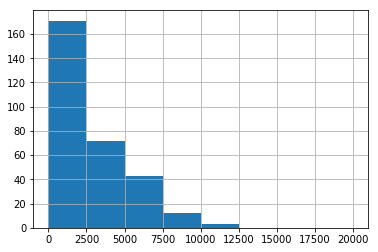

In [3]:
data1 = pd.read_csv("398908-5.csv", encoding = "GB2312")

#data1 = data1[data1["部件装上使用小时数"]!="00:00"]
data1["部件本次装机使用小时"] = data1["部件本次装机使用小时"].str.split(':').str[0].astype(int)
data1 = data1[data1["部件本次装机使用小时"]>0]

data1["IsPlanned"] = data1["非计划"]=="X"
print(data1["IsPlanned"].value_counts())
data_y = data1[["IsPlanned", "部件本次装机使用小时"]]
data_y["部件本次装机使用小时"].hist(bins=8, range=(0,20000))

data1["IsPlaneNew"] = data1["部件装上飞行小时数"]=="00:00"
data1["IsPartNew"] = data1["部件装上使用小时数"]=="00:00"
def CheckNew(p1,p2):
    if p1 and p2:
        return "PlaneNew-PartNew"
    elif p1 and not p2:
        return "PlaneNew-PartOld"
    elif not p1 and p2:
        return "PlaneOld-PartNew"
    elif not p1 and not p2:
        return "PlaneOld-PartOld"

#print([CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()])
data1["PlanePartType"] = [CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()]

data1["安装日期"] = pd.to_datetime(data1["安装日期"])
data1["安装年度"] = data1["安装日期"].dt.year

di = {"霍尼韦尔": "HONEYWELL"}
data1.replace({"最近送修公司": di}, inplace=True)
data1["最近送修公司"].fillna("Unknown", inplace=True)

data1["FH TSN"].fillna("00:00", inplace=True)
data1["部件装上飞行小时数"] = data1["部件装上飞行小时数"].str.split(':').str[0].astype(int)
data1["部件装上使用小时数"] = data1["部件装上使用小时数"].str.split(':').str[0].astype(int)

data1["部件装上飞行小时数-Range"] = pd.cut(data1['部件装上飞行小时数'], 8)
#data1["部件装上飞行循环数-Range"] = pd.cut(data1['部件装上飞行循环数'], 8)
data1["部件装上使用小时数-Range"] = pd.cut(data1['部件装上使用小时数'], 8)
#data1["部件装上使用循环数-Range"] = pd.cut(data1['部件装上使用循环数'], 8)
data1["CY TSN-Range"] = pd.cut(data1['CY TSN'], 8)
data1["FH TSN-Range"] = pd.cut(data1['FH TSN'], 8)

#data_x = data1[["机型","制造序列号","机号","参考类型","指令类型","序号","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","装上序号","最近送修公司","CY TSN","FH TSN"]]
#data_x = data1[["机型","参考类型","指令类型","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","CY TSN","FH TSN"]]
data_x = data1[["机型","安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", "最近送修公司","PlanePartType"]]

Text(0.5, 0, 'time $t$')

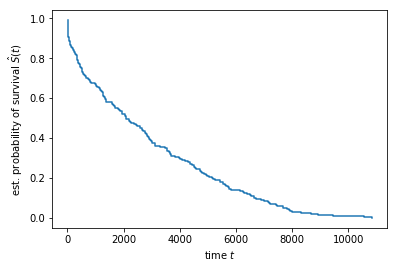

In [4]:
time, survival_prob = kaplan_meier_estimator(data_y["IsPlanned"], data_y["部件本次装机使用小时"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

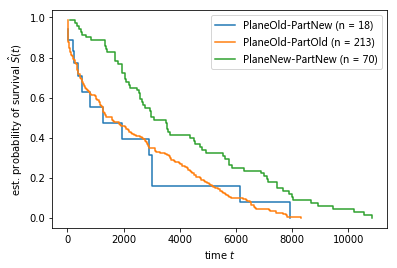

In [5]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "PlanePartType"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

y = data_y
x = data_x

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask],
                                                           y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

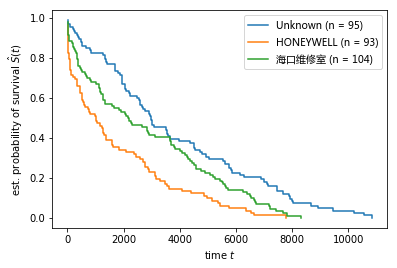

In [7]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "最近送修公司"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

filter1 = (data_x["最近送修公司"]!="武汉航达") & (data_x["最近送修公司"]!="PP") & (data_x["最近送修公司"]!="海航技术")
y = data_y[filter1]
x = data_x[filter1]

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask],
                                                           y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

In [8]:
#data_x.select_dtypes(exclude=['int','int64' 'float']).columns
data_x.describe()

,安装年度
count,301.000000
mean,2016.368771
std,0.912992
min,2010.000000
25%,2016.000000
50%,2016.000000
75%,2017.000000
max,2019.000000


In [9]:
#"部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range",
#
x = data_x.copy()
cat_features = ["机型", "安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", "最近送修公司","PlanePartType"]

for col in cat_features:
    x[col] = x[col].astype('category')

data_x_numeric = OneHotEncoder().fit_transform(x[cat_features])
data_x_numeric.head()

dropped categorical variable '机型', because it has only 1 values


,安装年度=2015,安装年度=2016,安装年度=2017,安装年度=2018,安装年度=2019,"部件装上飞行小时数-Range=(7038.25, 14076.5]","部件装上飞行小时数-Range=(14076.5, 21114.75]","部件装上飞行小时数-Range=(21114.75, 28153.0]","部件装上飞行小时数-Range=(28153.0, 35191.25]","部件装上飞行小时数-Range=(35191.25, 42229.5]",...,"FH TSN-Range=(35931.05, 44795.67]","FH TSN-Range=(44795.67, 53660.29]","FH TSN-Range=(53660.29, 62524.91]","FH TSN-Range=(62524.91, 71389.53]",最近送修公司=Unknown,最近送修公司=武汉航达,最近送修公司=海口维修室,最近送修公司=海航技术,PlanePartType=PlaneOld-PartNew,PlanePartType=PlaneOld-PartOld
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
null_columns=data1.columns[data1.isnull().any()]
data1[null_columns].isnull().sum()

故障描述           77
送修至拆下时间/FH    175
TLB号            2
dtype: int64

In [11]:
#data_y = data_y.as_matrix()
y = data_y.to_records(index=False)
estimator = CoxPHSurvivalAnalysis() #CoxnetSurvivalAnalysis()
estimator.fit(data_x_numeric, y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [12]:
#pd.Series(estimator.coef_, index=data_x_numeric.columns)

In [13]:
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(y["IsPlanned"], y["部件本次装机使用小时"], prediction)
print(result[0])
result = concordance_index_ipcw(y, y, prediction)
print(result[0])

0.7004318143439558
0.6994222448578928


In [14]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxnetSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

最近送修公司=Unknown                           0.572805
PlanePartType=PlaneOld-PartOld           0.565665
安装年度=2016                                0.563819
安装年度=2018                                0.562601
安装年度=2015                                0.553458
安装年度=2017                                0.550612
部件装上飞行小时数-Range=(28153.0, 35191.25]      0.521856
FH TSN-Range=(27066.43, 35931.05]        0.517755
部件装上飞行小时数-Range=(35191.25, 42229.5]      0.517466
FH TSN-Range=(9337.19, 18201.81]         0.516018
部件装上飞行小时数-Range=(49267.75, 56306.0]      0.514414
部件装上飞行小时数-Range=(14076.5, 21114.75]      0.514136
部件装上使用小时数-Range=(8647.625, 17295.25]     0.513075
FH TSN-Range=(18201.81, 27066.43]        0.511121
FH TSN-Range=(62524.91, 71389.53]        0.509288
部件装上飞行小时数-Range=(21114.75, 28153.0]      0.507454
部件装上使用小时数-Range=(17295.25, 25942.875]    0.506960
部件装上使用小时数-Range=(43238.125, 51885.75]    0.506188
PlanePartType=PlaneOld-PartNew           0.505802
FH TSN-Range=(53660.29, 62524.91]        0.505693


In [17]:
x_new = data_x_numeric.loc[[46,77,200,293]]
#print(x_new)
data_x.loc[[46,77,200,293]]

,机型,安装年度,部件装上飞行小时数-Range,部件装上使用小时数-Range,FH TSN-Range,最近送修公司,PlanePartType
46,73N,2015,"(-56.306, 7038.25]","(-69.181, 8647.625]","(9337.19, 18201.81]",Unknown,PlaneNew-PartNew
77,73N,2016,"(-56.306, 7038.25]","(17295.25, 25942.875]","(9337.19, 18201.81]",海口维修室,PlaneOld-PartOld
200,73N,2016,"(7038.25, 14076.5]","(-69.181, 8647.625]","(27066.43, 35931.05]",海口维修室,PlaneOld-PartOld
293,73N,2016,"(21114.75, 28153.0]","(-69.181, 8647.625]","(9337.19, 18201.81]",海口维修室,PlaneOld-PartOld


In [18]:
y[[46,77,200,293]]

rec.array([( True,  848), ( True,  516), ( True, 3692), ( True, 1272)],
          dtype=[('IsPlanned', '?'), ('部件本次装机使用小时', '<i8')])

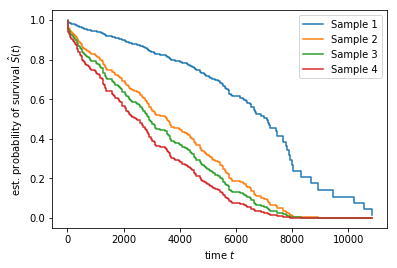

In [19]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [19]:
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [21]:
param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] -3)}
gcv = GridSearchCV(pipe, param_grid=param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(x, y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

LinAlgError: Matrix is singular.

In [22]:
pipe.set_params(**gcv.best_params_)
pipe.fit(x, y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Part2

In [20]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

In [21]:
data_x = data1[["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]]

In [22]:
def df_to_sarray(df):
    """
    Convert a pandas DataFrame object to a numpy structured array.
    This is functionally equivalent to but more efficient than
    np.array(df.to_array())

    :param df: the data frame to convert
    :return: a numpy structured array representation of df
    """

    v = df.values
    cols = df.columns

    if False:  # python 2 needs .encode() but 3 does not
        types = [(cols[i].encode(), df[k].dtype.type) for (i, k) in enumerate(cols)]
    else:
        types = [(cols[i], df[k].dtype.type) for (i, k) in enumerate(cols)]
    dtype = np.dtype(types)
    z = np.zeros(v.shape, dtype)
    for (i, k) in enumerate(z.dtype.names):
        z[:,i] = v[:, i]
    return z

In [23]:
y = data_y.to_records(index=False)
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2)#, random_state=1)
x_train = x_train.values
x_test = x_test.values

In [24]:
y_events_train = y_train[y_train['IsPlanned']==False]
train_min, train_max = y_events_train["部件本次装机使用小时"].min(), y_events_train["部件本次装机使用小时"].max()

y_events_test = y_test[y_test['IsPlanned']==False]
test_min, test_max = y_events_test["部件本次装机使用小时"].min(), y_events_test["部件本次装机使用小时"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

AssertionError: time range or test data is not within time range of training data.

In [25]:
times = np.percentile(data_y["部件本次装机使用小时"], np.linspace(5, 95, 15))
print(times)

[  14.           61.71428571  236.57142857  379.71428571  579.57142857
 1032.71428571 1349.         1920.         2466.85714286 2909.42857143
 3566.         4442.14285714 5212.71428571 6344.14285714 7476.        ]


In [26]:
import matplotlib
matplotlib.matplotlib_fname()

'/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

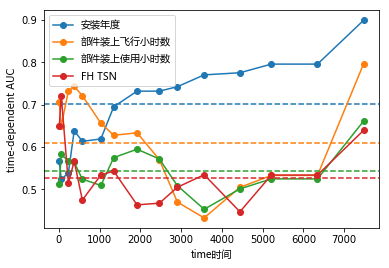

In [27]:
num_columns = ["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    
    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.legend(prop = font)
    
    plt.xlabel("time时间",fontproperties=font)
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

# Part3

In [28]:
data_x = data1[["机型","安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN", "最近送修公司","PlanePartType"]]

cat_features = ["机型", "安装年度", "最近送修公司","PlanePartType"]

for col in cat_features:
    data_x[col] =data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
times = np.percentile(data_y["部件本次装机使用小时"], np.linspace(5, 95, 15))
print(times)

[  14.           61.71428571  236.57142857  379.71428571  579.57142857
 1032.71428571 1349.         1920.         2466.85714286 2909.42857143
 3566.         4442.14285714 5212.71428571 6344.14285714 7476.        ]


dropped categorical variable '机型', because it has only 1 values
dropped categorical variable '机型', because it has only 1 values


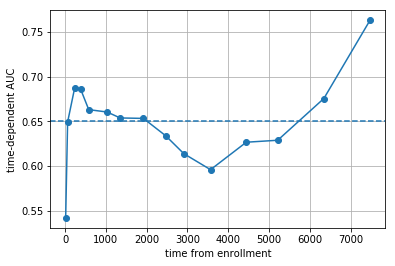

In [30]:
from sklearn.pipeline import make_pipeline

y = data_y.to_records(index=False)
va_x, va_y = data_x, y

cph = make_pipeline(OneHotEncoder(), CoxnetSurvivalAnalysis())
cph.fit(va_x, va_y)

# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), times)

plt.plot(times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("time from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Part4

In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

In [86]:
data_x = data1[["机型","安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN", "最近送修公司","PlanePartType"]]

cat_features = ["机型", "安装年度", "最近送修公司","PlanePartType"]

for col in cat_features:
    data_x[col] = data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
x = OneHotEncoder().fit_transform(data_x)#encode_categorical(data_x)

In [88]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

In [89]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['IsPlanned'], y['部件本次装机使用小时'], prediction)
    return result[0]

In [90]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=200, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, iid=False, refit=False,
                   cv=cv)

In [91]:
param_grid

{'alpha': array([2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
        6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
        1.60000000e+01, 6.40000000e+01, 2.56000000e+02, 1.02400000e+03,
        4.09600000e+03])}

In [92]:
import warnings
y = data_y.to_records(index=False)
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

In [93]:
gcv.best_score_, gcv.best_params_

(0.6888364339667064, {'alpha': 0.000244140625})

In [94]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

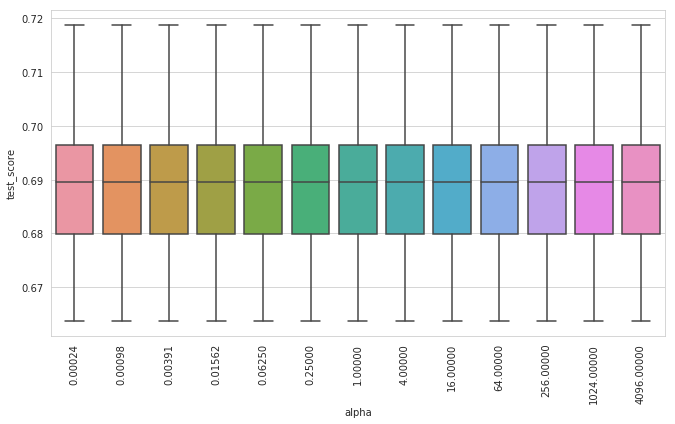

In [95]:
plot_performance(gcv)

In [96]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

In [97]:
kernel_matrix = clinical_kernel(data_x)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

In [98]:
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=4, iid=False, refit=False,
                    cv=cv)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(kernel_matrix, y)

In [ ]:
kgcv.best_score_, kgcv.best_params_

In [ ]:
plot_performance(kgcv)